# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [24]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [25]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [26]:
env=env.make_parallel_env(parallel_envs)

AttributeError: 'UnityEnvironment' object has no attribute 'make_parallel_env'

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [27]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [28]:
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.
在下一个代码单元中，您将学习如何使用Python API来控制代理并接收来自环境的反馈。
Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.请注意，在此编码环境中，您将无法在座席训练时观看他们，因此应设置train_mode = True以重新启动环境。

In [29]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        # 
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        # 由网络输出动作
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        # 截取动作的范围
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        # 将动作传递给环境
        next_states = env_info.vector_observations         # get next state (for each agent)
        # 获取变化后的环境值
        rewards = env_info.rewards                         # get reward (for each agent)
        # 获得相应的奖励
        dones = env_info.local_done                        # see if episode finished
        # 判断是否事终止状态
        scores += env_info.rewards                         # update the score (for each agent)
        # 更新分数
        states = next_states                               # roll over states to next time step
        # 更新状态值
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [30]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [31]:
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import os
%matplotlib inline
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

In [32]:
EXPERIENCE_POOL_SIZE = 1000000 # define the experience pool size
BATCH_SIZE = 128 # minibatch size
LR_ACTOR = 0.001 # actor network learning rate
LR_CRITIC = 0.001 # critic network learning rate
WEIGHT_DECAY = 0 # L2 weight decay
LEARN_EVERY = 1 # learning interval
LEARN_NUM = 4 # learning coefficient
GAMMA = 0.99 # discount factor
TAU = 7e-2 # soft update parameters
OU_SIGMA = 0.2 # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15 # Ornstein-Uhlenbeck noise parameter, mean recovery speed
EPS_START = 6.0 # Initial value of ε during noise attenuation
EPS_EPOSIDE_END = 300 # End noise attenuation after a specified number of trainings
EPS_FINAL = 0 # final value of ε after attenuation
GOAL_SCORE = 0.5 # goal score
WINDOW_LENGTH = 100 # limited number of actions
PRINT_EVERY = 10 # print the score every tenth time
ADD_NOISE = True # add noise

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
### Construction of neural network ###
def hidden_init(layer):
    x = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(x)
    return (-lim, lim)

class Network(nn.Module): 
    def __init__(self,input_dim,output_dim,seed,fc1_units=32,fc2_units=16,actor=False):
        super(Network, self).__init__()
        self.actor = actor
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_dim*2, fc1_units)
        if self.actor:  
            self.fc2 = nn.Linear(fc1_units, fc2_units)
        else:
            self.fc2 = nn.Linear(fc1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_dim)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-1e-3, 1e-3)
    def forward(self, state, action):
        if self.actor:  
            h1 = F.relu(self.fc1(state))
            h2 = F.relu(self.fc2(h1))
            h3 = torch.tanh(self.fc3(h2))
            return h3
        else:  
            h1 = F.relu(self.fc1(state))
            h2 = torch.cat((h1, action), dim=1)
            h3 = F.relu(self.fc2(h2))
            return self.fc3(h3)
    
### Define agents, including behavior functions, learning functions, soft updates, etc. ###
class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.timestep = 0
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        # epsilon attenuation
        self.eps = EPS_START
        self.eps_decay = 1/(EPS_EPOSIDE_END*LEARN_NUM)  
        # Neural network building
        self.actor = Network(state_size, action_size, random_seed, actor=True).to(device)
        self.actor_target = Network(state_size, action_size, random_seed, actor=True).to(device)
        self.critic = Network(state_size, action_size, random_seed).to(device)
        self.critic_target = Network(state_size, action_size, random_seed).to(device)
        # Optimizer definition
        self.actor_optimizer = Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Motion noise
        self.noise = OUNoise((num_agents, action_size), random_seed) 
        # Experience Replay
        self.memory = Experience_Replay(action_size, EXPERIENCE_POOL_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, agent_number): 
        self.timestep += 1
        # Store data to experience pool after each step
        self.memory.add(state, action, reward, next_state, done)
        # Start learning the experience pool data when there are enough samples
        if len(self.memory) > BATCH_SIZE and self.timestep % LEARN_EVERY == 0:
            for _ in range(LEARN_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA, agent_number)
    
    def target_act(self, obs_all_agents, noise=0.0):
        target_actions = [ddpg_agent.target_act(obs, noise) for ddpg_agent, obs in zip\
                          (self.maddpg_agent,obs_all_agents)]
        return target_actions
    
    def act(self, states, add_noise): # Executing the current policy returns two operations and outputs the action
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor.eval()
        with torch.no_grad(): # Organize state action pairs and pass them to the actor network to output the next action
            for agent_num, state in enumerate(states):
                action = self.actor(state,actions).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor.train()
        if add_noise:
            actions += self.eps * self.noise.sample()
        actions = np.clip(actions, -1, 1)
        return actions

    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma, agent_number):
        states, actions, rewards, next_states, dones = experiences
        ###  critic network parameter update   ###
        actions_next = self.actor_target(next_states,actions)
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)

        Q_targets_next = self.critic_target(next_states, actions_next)  
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Calculate critic network loss
        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()
        ###  actor network parameter update  ###
        actions_pred = self.actor(states,actions)
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        actor_loss = -self.critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        ###  Soft update ###
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)
        # Update noise parameters
        self.eps -= self.eps_decay
        self.eps = max(self.eps, EPS_FINAL)
        self.noise.reset()
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### OU Noise function ###            
class OUNoise:
    def __init__(self, size, seed, mu=0.0, theta=OU_THETA, sigma=OU_SIGMA):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
### Experience Replay function ###    
class Experience_Replay:
    def __init__(self, action_size, EXPERIENCE_POOL_SIZE, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=EXPERIENCE_POOL_SIZE)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):# Add sample
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):# Random sampling
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [38]:
### Agent initialization ###
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

### Integrate behavioral functions of multiple agents and adjust data format ###
def get_actions(states, add_noise): 
    action_0 = agent_0.act(states, add_noise)    
    action_1 = agent_1.act(states, add_noise)    
    return np.concatenate((action_0, action_1), axis=0).flatten()
def transpose_to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float)
    return list(map(make_tensor, zip(*input_list)))

In [39]:
n_episodes=2000
max_t=2000
train_mode=True
scores_window = deque(maxlen=WINDOW_LENGTH)
scores_all = []
moving_average = []
best_score = -np.inf
best_episode = 0
already_solved = False    

### Start loop learning ###

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=train_mode)[brain_name]     # Reset environment
    states =  np.reshape(env_info.vector_observations, (1,48))  # Combining state characteristics of two agents
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        actions = get_actions(states, ADD_NOISE)            # Select proxy actions and combine them
        env_info = env.step(actions)[brain_name]            # Output two actions to the environment together
        next_states = np.reshape(env_info.vector_observations,(1, 48)) # Output next state
        rewards = env_info.rewards                          # Get reward
        done = env_info.local_done                          # See if the plot is over
        agent_0.step(states, actions, rewards[0], next_states, done, 0) # Agent 1 learning
        agent_1.step(states, actions, rewards[1], next_states, done, 1) # Agent 2 learning
        scores += np.max(rewards)                           # Update record score
        states = next_states                                # Update status characteristics
        if np.any(done):                                    
            break
    
    # Record scores for easy mapping
    ep_best_score = np.max(scores) 
    scores_window.append(ep_best_score)
    scores_all.append(ep_best_score)
    moving_average.append(np.mean(scores_window))
                    
    if ep_best_score > best_score:# Save the best score
        best_score = ep_best_score
        best_episode = i_episode
    if i_episode % PRINT_EVERY == 0: # Determine the length of time and print the data
        print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
            i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
    
    if moving_average[-1] >= GOAL_SCORE:# Determine if environmental issues are resolved and save the model
        if not already_solved:
            print('<-- Environment solved in {:d} episodes! \
            \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                i_episode-WINDOW_LENGTH, moving_average[-1], WINDOW_LENGTH))
            already_solved = True
            torch.save(agent_0.actor.state_dict(), 'model_dir/actor_weight.pth')
            torch.save(agent_0.critic.state_dict(), 'model_dir/critic_weight.pth')
            torch.save(agent_1.actor.state_dict(), 'model_dir/actor_target_weight.pth')
            torch.save(agent_1.critic.state_dict(), 'model_dir/critic_target_weight.pth')
        elif ep_best_score >= best_score:
            print('<-- Best episode so far!\
            \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
            i_episode, ep_best_score, moving_average[-1]))
            torch.save(agent_0.actor.state_dict(), 'model_dir/actor_weight.pth')
            torch.save(agent_0.critic.state_dict(), 'model_dir/critic_weight.pth')
            torch.save(agent_1.actor.state_dict(), 'model_dir/actor_target_weight.pth')
            torch.save(agent_1.critic.state_dict(), 'model_dir/critic_target_weight.pth')
        elif (i_episode-best_episode) >= 200: # Determine if the model has stopped converging
            print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
            break
        else:
            continue

Episodes 0000-0010	Max Reward: 0.100	Moving Average: 0.010
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.010
Episodes 0020-0030	Max Reward: 0.100	Moving Average: 0.010
Episodes 0030-0040	Max Reward: 0.000	Moving Average: 0.008
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.006
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.007
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.009
Episodes 0070-0080	Max Reward: 0.000	Moving Average: 0.008
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.009
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.009
Episodes 0100-0110	Max Reward: 0.000	Moving Average: 0.008
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.010
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.011
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.014
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.015
Episodes 0150-0160	Max Reward: 0.100	Moving Average: 0.016
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

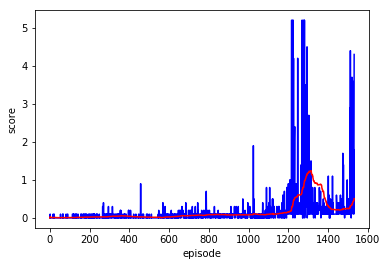

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_all)), scores_all, c='b', label='MADDPG')
plt.plot(np.arange(len(scores_all)), moving_average, c='r', label='moving average')
plt.ylabel('score')
plt.xlabel('episode')
plt.show()

In [62]:
env.close()